In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dsets

from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.manual_seed(232)
use_gpu = False

# Hyper Parameters 
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 100
batch_size = 100
learning_rate = 0.01

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Processing...
Done!


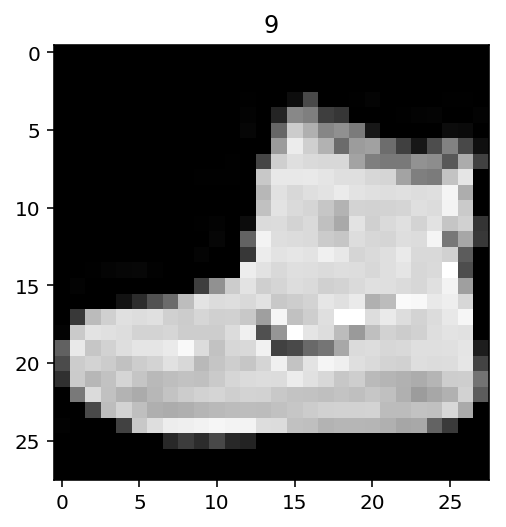

In [4]:
plt.imshow(train_loader.dataset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

In [5]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal(m.weight.data)
        #nn.init.orthogonal(m.bias.data)

In [17]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_p=0.5):
        super(Net, self).__init__()
        self.dropout_p = dropout_p
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=True)
        x = self.fc3(x)
        
        y = F.log_softmax(x, dim=0)
        return y        

In [1]:
model = Net(input_size, hidden_size, num_classes, dropout_p=0.5)
#apply weigth initialization
#model.apply(weights_init)

#if use_gpu:
#    model.cuda()
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay = 0.0,momentum=0.9)

#optimizer = torch.optim.Adam(model.parameters(),
#                             lr=0.001, 
#                             betas=(0.9, 0.99), 
#                             eps=1e-08, 
#                             weight_decay=0, 
#                             amsgrad=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70, 90])

NameError: name 'Net' is not defined

In [2]:
mean_trainloss, std_trainloss = [], []
mean_testloss, std_testloss = [], []
# Train the Model
for epoch in range(num_epochs):
    #Train step
    model.train()
    epoch_trainloss = []
    for train_images, train_labels in train_loader:  
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        # Convert torch tensor to Variable
        train_images = train_images.view(-1, 28*28)
        train_labels = train_labels
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        train_outputs = model(train_images)
        train_loss = F.nll_loss(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        epoch_trainloss.append(train_loss.detach().numpy())
    mean_trainloss.append(np.mean(epoch_trainloss))
    std_trainloss.append(np.std(epoch_trainloss))
    
    #scheduler.step()
    
    #Test step
    model.eval()
    epoch_testloss = []
    for test_images, test_labels in test_loader:
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        test_images = test_images.view(-1, 28*28)
        test_labels = test_labels
        
        #Forward
        test_outputs = model(test_images)
        test_loss = F.nll_loss(test_outputs, test_labels)
        epoch_testloss.append(test_loss.detach().numpy())
    mean_testloss.append(np.mean(epoch_testloss))
    std_testloss.append(np.std(epoch_testloss))
    
    print (f'''Epoch {epoch+1}/{num_epochs}, 
    trainloss: {np.mean(epoch_trainloss)}, 
    testloss : {np.mean(epoch_testloss)}''')

NameError: name 'num_epochs' is not defined

In [29]:
correct = 0
total = 0
for images, labels in test_loader:
    images = images.view(-1, 28*28)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
testset_accuracy= round(100*correct.numpy()/total,2)
print(testset_accuracy)

80.87


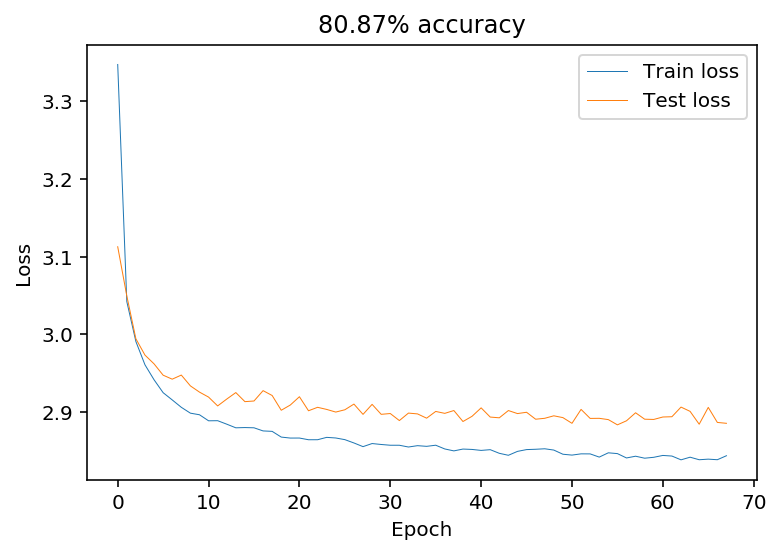

In [30]:
plt.plot(mean_trainloss, label='Train loss',linewidth=0.5)
plt.plot(mean_testloss, label='Test loss', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{testset_accuracy}% accuracy')
plt.legend()
#plt.savefig('300hidden_defaultinit_001lr_weird.pdf', format='pdf')

In [16]:
#torch.save(model.state_dict(),f='onehiddenlayer_200epoch.pt')

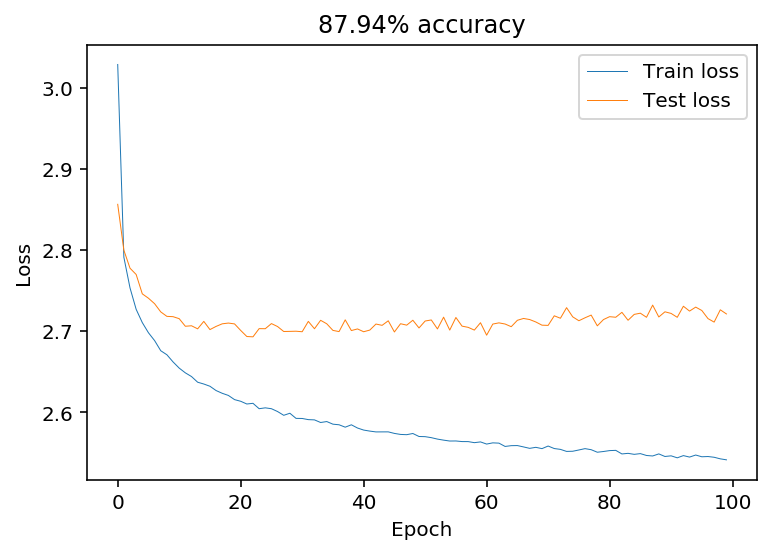

In [21]:
plt.plot(mean_trainloss, label='Train loss',linewidth=0.5)
plt.plot(mean_testloss, label='Test loss', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{testset_accuracy}% accuracy')
plt.legend()